# Exercise 1.
Implement BA algorithm. - From slide 17/52
Barabási, A.-L., & Albert, R. (1999).
Emergence of scaling in random networks.

Node 0: degree = 11
Node 1: degree = 7
Node 2: degree = 6
Node 3: degree = 2
Node 4: degree = 5
Node 5: degree = 5
Node 6: degree = 3
Node 7: degree = 2
Node 8: degree = 3
Node 9: degree = 2
Node 10: degree = 6
Node 11: degree = 2
Node 12: degree = 3
Node 13: degree = 2
Node 14: degree = 3
Node 15: degree = 4
Node 16: degree = 2
Node 17: degree = 2
Node 18: degree = 2
Node 19: degree = 2


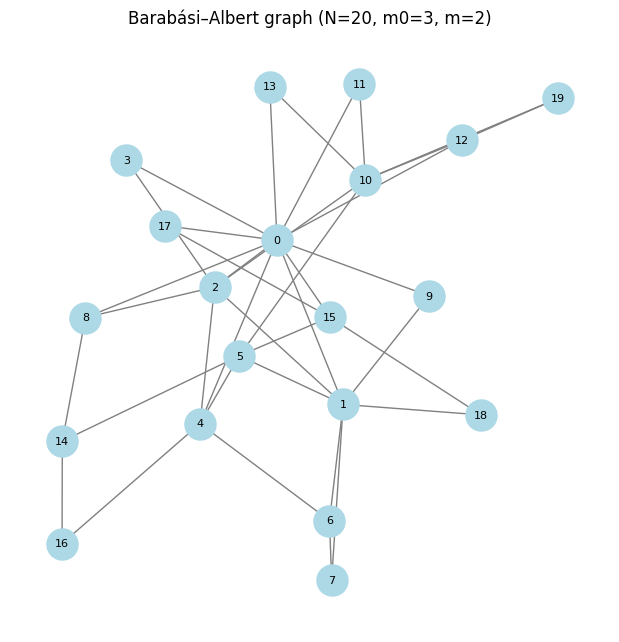

In [3]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def barabasi_albert_graph(N, m0=3, m=2, seed=None):
    if seed is not None:
        random.seed(seed)

    graph = [set() for _ in range(N)]

    for i in range(m0):
        for j in range(i + 1, m0):
            graph[i].add(j)
            graph[j].add(i)

    degree_list = []
    for i in range(m0):
        degree_list.extend([i] * len(graph[i]))

    for new_node in range(m0, N):
        targets = set()
        while len(targets) < m:
            chosen = random.choice(degree_list)
            targets.add(chosen)

        for t in targets:
            graph[new_node].add(t)
            graph[t].add(new_node)

        degree_list.extend([new_node] * m)
        for t in targets:
            degree_list.append(t)

    return graph


N = 20
m0 = 3
m = 2

G_list = barabasi_albert_graph(N, m0, m, seed=42)

degrees = [len(neighbors) for neighbors in G_list]
for i, deg in enumerate(degrees):
    print(f"Node {i}: degree = {deg}")

G_nx = nx.Graph()
G_nx.add_nodes_from(range(N))
for u, neighbors in enumerate(G_list):
    for v in neighbors:
        if u < v:
            G_nx.add_edge(u, v)

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G_nx, seed=0)

nx.draw(
    G_nx,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    node_size=500,
    font_size=8,
)

plt.title("Barabási–Albert graph (N=20, m0=3, m=2)")
plt.axis("off")
plt.show()


# Exercise 2.
Use it to create an animation of a growing graph.

GIF saved as ba_growth.gif


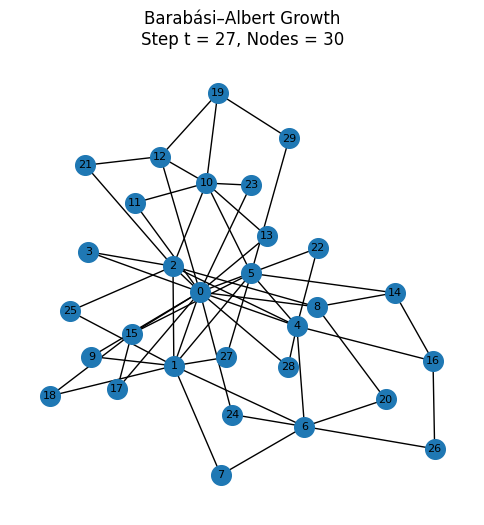

In [4]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def barabasi_albert_graph(N, m0=3, m=2, seed=None, return_snapshots=False):
    if seed is not None:
        random.seed(seed)

    graph = [set() for _ in range(N)]

    for i in range(m0):
        for j in range(i + 1, m0):
            graph[i].add(j)
            graph[j].add(i)

    degree_list = []
    for i in range(m0):
        degree_list.extend([i] * len(graph[i]))

    snapshots = []

    def to_nx_graph(current_n):
        G = nx.Graph()
        G.add_nodes_from(range(current_n))
        for u in range(current_n):
            for v in graph[u]:
                if v < current_n:
                    G.add_edge(u, v)
        return G

    if return_snapshots:
        snapshots.append(to_nx_graph(m0))

    for new_node in range(m0, N):
        targets = set()
        while len(targets) < m:
            selected = random.choice(degree_list)
            if selected != new_node:
                targets.add(selected)

        for t in targets:
            graph[new_node].add(t)
            graph[t].add(new_node)

        degree_list.extend([new_node] * m)
        for t in targets:
            degree_list.append(t)

        if return_snapshots:
            snapshots.append(to_nx_graph(new_node + 1))

    if return_snapshots:
        return graph, snapshots

    return graph

N = 30
m0 = 3
m = 2

graph, snapshots = barabasi_albert_graph(N, m0=m0, m=m, seed=42, return_snapshots=True)

final_graph = snapshots[-1]
pos = nx.spring_layout(final_graph, seed=1)

fig, ax = plt.subplots(figsize=(6, 6))

def update(frame):
    ax.clear()
    G = snapshots[frame]
    nx.draw(
        G,
        pos=pos,
        ax=ax,
        with_labels=True,
        node_size=200,
        font_size=8
    )
    ax.set_title(f"Barabási–Albert Growth\nStep t = {frame}, Nodes = {G.number_of_nodes()}")

ani = FuncAnimation(
    fig,
    update,
    frames=len(snapshots),
    interval=500,
    repeat=False
)

ani.save("ba_growth.gif", writer="pillow", fps=2)
print("GIF saved as ba_growth.gif")

plt.show()


# Exercise 3.
Plot the (averaged) histogram of the degree distribution at time t.

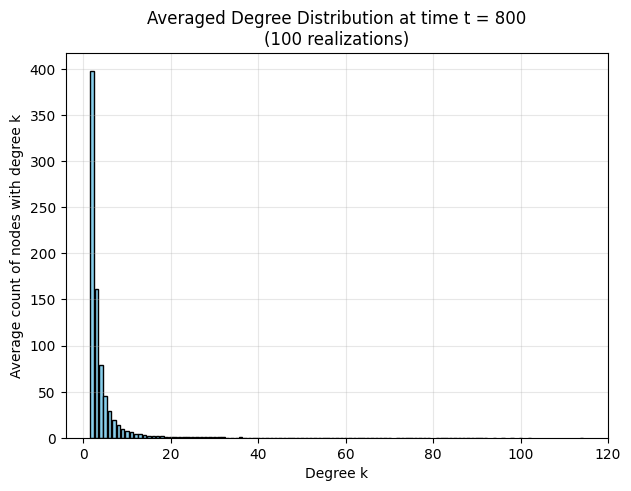

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def get_degree_distribution(graph):
    degrees = [len(neighbors) for neighbors in graph]
    return Counter(degrees)

N = 800
t = 800
m0 = 3
m = 2
realizations = 100

all_degree_counts = Counter()

for _ in range(realizations):
    graph = barabasi_albert_graph(N, m0=m0, m=m)
    t_graph = graph[:t]
    dist = get_degree_distribution(t_graph)
    all_degree_counts.update(dist)

for k in all_degree_counts:
    all_degree_counts[k] /= realizations

degrees = sorted(all_degree_counts.keys())
counts = [all_degree_counts[k] for k in degrees]

plt.figure(figsize=(7, 5))
plt.bar(degrees, counts, color='skyblue', edgecolor='black')
plt.xlabel("Degree k")
plt.ylabel("Average count of nodes with degree k")
plt.title(f"Averaged Degree Distribution at time t = {t}\n({realizations} realizations)")
plt.grid(alpha=0.3)

plt.show()


# Exercise 4.
Find the α coefficient for the data from the previous tasks. Does it
agree with our theoretical result from the lecture?

Estimated alpha (linear fit) = 2.5513606594681226
Estimated alpha (MLE)        = 3.0575201330245982
Theoretical BA result: alpha = 3


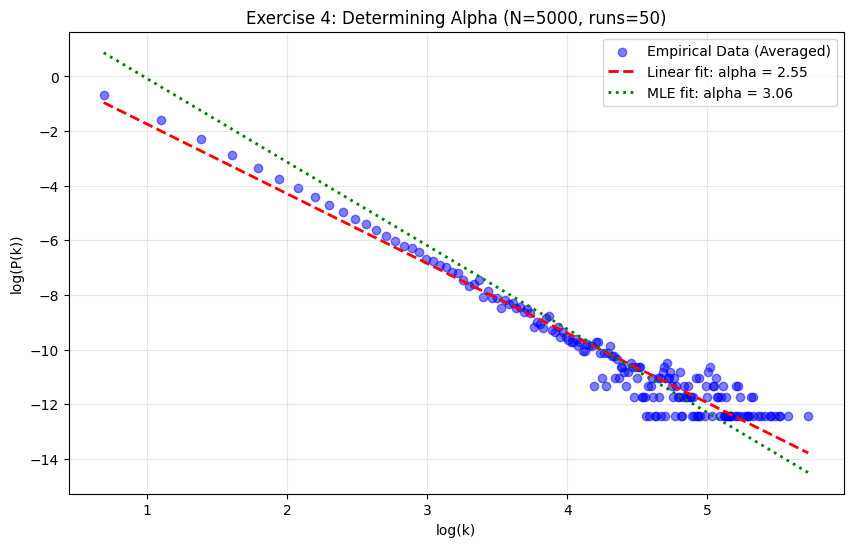

In [6]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

def get_degrees_from_graph(graph):
    return [len(neighs) for neighs in graph]

def alpha_linear_fit_return(degrees):
    degrees_arr = np.array(degrees)
    k, counts = np.unique(degrees_arr, return_counts=True)
    mask = (k > 0) & (counts > 0)
    k = k[mask]
    pk = counts[mask] / np.sum(counts)
    log_k = np.log(k)
    log_pk = np.log(pk)
    a, b = np.polyfit(log_k, log_pk, 1)
    alpha = -a
    return alpha, k, pk, a, b

def alpha_mle(degrees, k_min):
    data = np.array(degrees)
    data = data[data >= k_min]
    n = len(data)
    return 1 + n / np.sum(np.log(data / k_min))

N = 5000
m0 = 3
m = 2
num_runs = 50
k_min = 8

all_degrees = []
for _ in range(num_runs):
    g = barabasi_albert_graph(N, m0=m0, m=m)
    all_degrees.extend(get_degrees_from_graph(g))

alpha_lin, k_vals, pk_vals, slope, intercept = alpha_linear_fit_return(all_degrees)
alpha_mle_val = alpha_mle(all_degrees, k_min)
alpha_mle = alpha_mle_val

print("Estimated alpha (linear fit) =", alpha_lin)
print("Estimated alpha (MLE)        =", alpha_mle_val)
print("Theoretical BA result: alpha = 3")

mask = pk_vals > 0
log_k = np.log(k_vals[mask])
log_pk = np.log(pk_vals[mask])

C_mle = np.mean(log_pk + alpha_mle * log_k)
log_pk_mle = -alpha_mle * log_k + C_mle

plt.figure(figsize=(10, 6))

plt.scatter(log_k, log_pk, color='blue', alpha=0.5, label='Empirical Data (Averaged)')

plt.plot(
    log_k,
    slope * log_k + intercept,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Linear fit: alpha = {alpha_lin:.2f}'
)

plt.plot(
    log_k,
    log_pk_mle,
    color='green',
    linestyle=':',
    linewidth=2,
    label=f'MLE fit: alpha = {alpha_mle:.2f}'
)

plt.title(f"Exercise 4: Determining Alpha (N={N}, runs={num_runs})")
plt.xlabel("log(k)")
plt.ylabel("log(P(k))")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



# Exercise 5.
Check with simulations relation ki(t). Compare the predictions of the
obtained formulas with the ”empirical” data from simpulations.

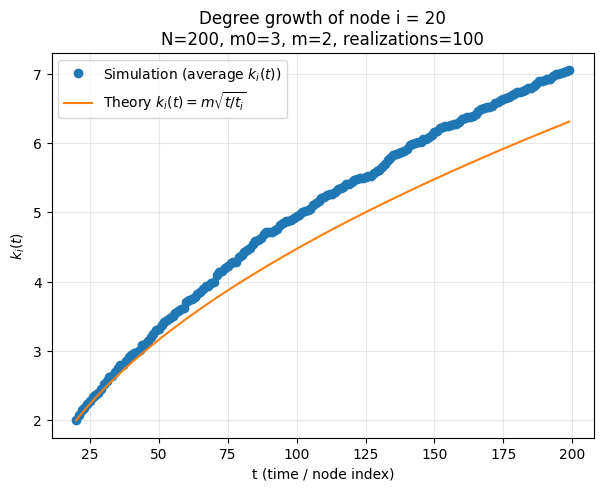

In [40]:
import random
import numpy as np
import matplotlib.pyplot as plt

def simulate_ki_vs_t_with_snapshots(N=200, m0=3, m=2, node_i=10, realizations=50, seed=None):
    if seed is not None:
        random.seed(seed)

    num_points = N - node_i
    sum_degrees = np.zeros(num_points, dtype=float)

    for r in range(realizations):
        graph, snapshots = barabasi_albert_graph(
            N,
            m0=m0,
            m=m,
            seed=None,
            return_snapshots=True
        )

        for G in snapshots:
            current_n = G.number_of_nodes()
            t = current_n - 1
            if t >= node_i:
                idx = t - node_i
                if idx < num_points and node_i < current_n:
                    sum_degrees[idx] += G.degree(node_i)

    avg_degrees = sum_degrees / realizations
    t_values = np.arange(node_i, N)
    t_i = node_i
    k_theory = m * np.sqrt(t_values / t_i)

    return t_values, avg_degrees, k_theory

N = 200
m0 = 3
m = 2
node_i = 20
realizations = 100

t_vals, k_avg, k_th = simulate_ki_vs_t_with_snapshots(
    N=N,
    m0=m0,
    m=m,
    node_i=node_i,
    realizations=realizations,
    seed=42
)

plt.figure(figsize=(7, 5))
plt.plot(t_vals, k_avg, "o", label="Simulation (average $k_i(t)$)")
plt.plot(t_vals, k_th, "-", label=r"Theory $k_i(t) = m \sqrt{t / t_i}$")
plt.xlabel("t (time / node index)")
plt.ylabel(r"$k_i(t)$")
plt.title(f"Degree growth of node i = {node_i}\nN={N}, m0={m0}, m={m}, realizations={realizations}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# P6.3
 Check with simulations result obtained for model A.

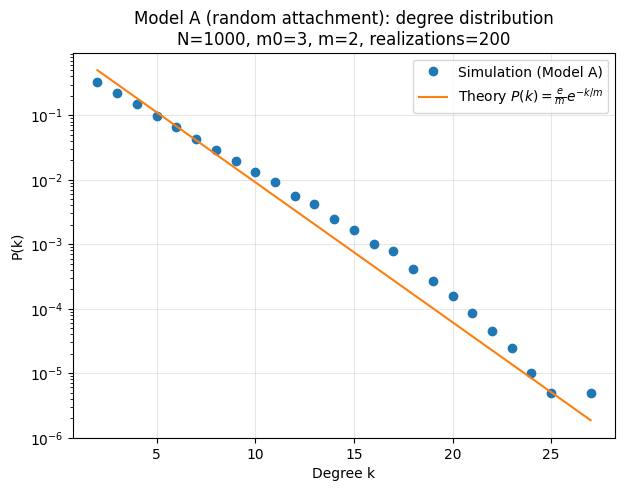

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def random_attachment_graph(N, m0=3, m=2, seed=None):
    if seed is not None:
        random.seed(seed)

    graph = [set() for _ in range(N)]

    for i in range(m0):
        for j in range(i + 1, m0):
            graph[i].add(j)
            graph[j].add(i)

    for new_node in range(m0, N):
        existing_nodes = list(range(new_node))
        targets = set(random.sample(existing_nodes, m))
        for t in targets:
            graph[new_node].add(t)
            graph[t].add(new_node)

    return graph

def averaged_degree_distribution_random_model(
    N=200, m0=3, m=2, realizations=100, seed=None
):
    if seed is not None:
        random.seed(seed)

    degree_counter = Counter()

    for _ in range(realizations):
        g = random_attachment_graph(N, m0=m0, m=m)
        degrees = [len(neigh) for neigh in g]
        degree_counter.update(degrees)

    total_nodes = realizations * N
    ks = sorted(degree_counter.keys())
    P_emp = np.array([degree_counter[k] / total_nodes for k in ks])

    return np.array(ks), P_emp

N = 1000
m0 = 3
m = 2
realizations = 200

ks, P_emp = averaged_degree_distribution_random_model(
    N=N, m0=m0, m=m, realizations=realizations, seed=42
)

ks_th = ks
P_th = (np.e / m) * np.exp(-ks_th / m)

plt.figure(figsize=(7, 5))
plt.semilogy(ks, P_emp, "o", label="Simulation (Model A)")
plt.semilogy(ks_th, P_th, "-", label=r"Theory $P(k)=\frac{e}{m}e^{-k/m}$")
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.title(
    f"Model A (random attachment): degree distribution\n"
    f"N={N}, m0={m0}, m={m}, realizations={realizations}"
)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


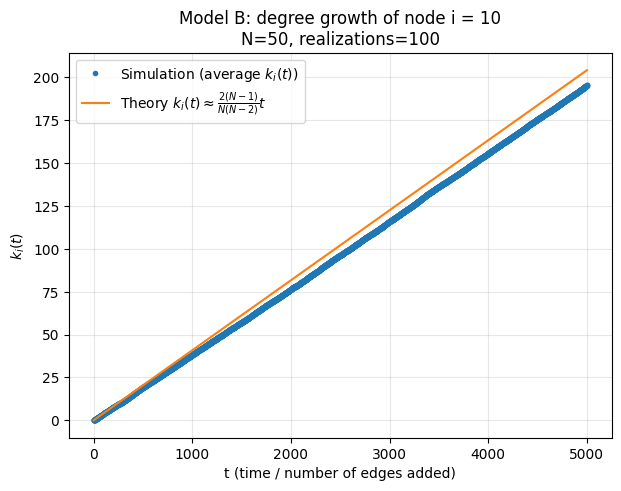

In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt

def simulate_modelB_ki_vs_t(N=50, T=5000, node_i=0, realizations=50, seed=None):
    if seed is not None:
        random.seed(seed)

    sum_degrees = np.zeros(T, dtype=float)

    for r in range(realizations):
        degrees = [0] * N

        u0, v0 = 0, 1
        degrees[u0] += 1
        degrees[v0] += 1

        for t in range(T):
            total_degree = sum(degrees)

            if total_degree == 0:
                u = random.randrange(N)
            else:
                degree_list = []
                for v in range(N):
                    degree_list.extend([v] * degrees[v])
                u = random.choice(degree_list)

            v = u
            while v == u:
                v = random.randrange(N)

            degrees[u] += 1
            degrees[v] += 1

            sum_degrees[t] += degrees[node_i]

    k_avg = sum_degrees / realizations
    t_values = np.arange(1, T + 1)

    if N > 2:
        k_theory = 2 * (N - 1) / (N * (N - 2)) * t_values
    else:
        k_theory = 2 / N * t_values

    return t_values, k_avg, k_theory

N = 50
T = 5000
node_i = 10
realizations = 100

t_vals, k_avg, k_th = simulate_modelB_ki_vs_t(
    N=N,
    T=T,
    node_i=node_i,
    realizations=realizations,
    seed=42
)

plt.figure(figsize=(7, 5))
plt.plot(t_vals, k_avg, "o", markersize=3, label="Simulation (average $k_i(t)$)")
plt.plot(t_vals, k_th, "-", label=r"Theory $k_i(t) \approx \frac{2(N-1)}{N(N-2)} t$")
plt.xlabel("t (time / number of edges added)")
plt.ylabel(r"$k_i(t)$")
plt.title(
    f"Model B: degree growth of node i = {node_i}\n"
    f"N={N}, realizations={realizations}"
)
plt.legend()
plt.grid(alpha=0.3)
plt.show()
